Ćwiczenie:
- pobierz i wczytaj zbiór danych SMS Spam Collection
- dokonaj eksploracyjnej analizy danych
    - jaka jest proporcja klas w zbiorze?
    - czy wszystkie wiadomości są unikatowe? Jeżeli nie, jakie wiadomości najczęściej występują w każdej z klas? Czy jakaś wiadomość występuje w obu klasach?
    - jakiej długości są wiadomości?
    - jakie słowa najczęściej (top 16) występują w wiadomościach? Czy są różnice pomiędzy klasami?
- dokonaj preprocessingu danych
    - wyeliminuj znaki interpunkcyjne z wiadomości
    - zamień wielkie litery na małe
    - podziel wiadomości na tokeny (słowa)
    - przekonwertuj tokeny na lemma (nltk.stem.wordnet.WordNetLemmatizer)
    - dla losowych 8 wiadomości z każdej klasy porównaj wynik lemmizacji z wynikiem działania oryginalnego algorytmu Portera (nltk.stem.porter.PorterStemmer)
    - przy użyciu nltk.corpus.stopwords usuń słowa o małym znaczeniu
        czy lista ta jest wystarczająca aby poradzić sobie ze slangiem SMSowym? Jeżeli nie, uzupełnij ją.
    - czy zmieniły się listy najczęściej występujących słów (lemm)?
    - dokonaj wektoryzacji lemm na wektory cech (sklearn.feature_extraction.text.CountVectorizer)
- naucz klasyfikator
    - naucz naiwny klasyfikator Bayesa (sklearn.naive_bayes.MultinomialNB)
    - wyświetl confusion matrix
    - przy założeniu że klasyfikator będzie automatycznie (tj. bez żadnej kontroli ze strony użytkownika) usuwał spam, jaki rodzaj błędu należy zminimalizować? (typ 1 czy typ 2)
    - kontrolując parametr alpha zminimalizuj (przy użyciu metody numerycznej) błąd wybrany w poprzednim poleceniu
    - wyświetl confusion matrix
    - porównaj wyniki (accuracy i confusion matrix) z DummyClassifier
    - czy nauczony klasyfikator poprawnie klasyfikuje poniższy mail?

Dear Sir:
I have been requested by the Nigerian National Petroleum Company to contact you for assistance in resolving a matter. The Nigerian National Petroleum Company has recently concluded a large number of contracts for oil exploration in the sub-Sahara region. The contracts have immediately produced moneys equaling US$40,000,000. The Nigerian National Petroleum Company is desirous of oil exploration in other parts of the world, however, because of certain regulations of the Nigerian Government, it is unable to move these funds to another region.
You assistance is requested as a non-Nigerian citizen to assist the Nigerian National Petroleum Company, and also the Central Bank of Nigeria, in moving these funds out of Nigeria. If the funds can be transferred to your name, in your United States account, then you can forward the funds as directed by the Nigerian National Petroleum Company. In exchange for your accommodating services, the Nigerian National Petroleum Company would agree to allow you to retain 10%, or US$4 million of this amount.
However, to be a legitimate transferee of these moneys according to Nigerian law, you must presently be a depositor of at least US$100,000 in a Nigerian bank which is regulated by the Central Bank of Nigeria.
If it will be possible for you to assist us, we would be most grateful. We suggest that you meet with us in person in Lagos, and that during your visit I introduce you to the representatives of the Nigerian National Petroleum Company, as well as with certain officials of the Central Bank of Nigeria.
Please call me at your earliest convenience at 18-467-4975. Time is of the essence in this matter; very quickly the Nigerian Government will realize that the Central Bank is maintaining this amount on deposit, and attempt to levy certain depository taxes on it.
Yours truly,
Prince Alyusi Islassis

Laboratorium 6:

- eksploracja danych (za każdy z podpunktów):
    - wykres (na każde pytanie da się udzielić odpowiedzi w formie odpowiednich histogramów) - 1pkt
    - słowna, uzasadniona (odwołująca się do wykresu) odpowiedź na pytanie - 1pkt
- preprocessing danych:
    - po 1 pkt za każdy z podpunktów
    - uzasadnienie czy konieczna jest modyfikacja listy słów o małym znaczeniu (i jej ew. uzupełnienie) - 1pkt
- klasyfikator:
    - po 1 pkt za każdy z podpunktów
        - oczekiwany jest także poprawny podział na zbiory testowe i treningowe
        - w pytaniu o rodzaj błędu oczekiwane jest uzasadnienie
        - nie ma konieczności implementowania własnej metody numerycznej, w pakiecie scipy.optimize jest szeroka gama funkcji do wyboru
        - z DummyClassifier porównywany jest klasyfikator z optymalnym alpha, w punkcie tym oczekiwane są wnioski dot. jakości uzyskanego klasyfikatora (Czy jest lepszy niż brak klasyfikatora?)
   - uzasadnienie/ wnioski do ostatniego pytania - 1pkt

pobieram i wczytuje zbiór danych SMS Spam Collection

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.pipeline import Pipeline
import scipy
from sklearn.dummy import DummyClassifier

In [2]:
data_ham = []
data_spam = []
with open('smsspamcollection/SMSSpamCollection', 'r') as fp:
    lines = fp.read().splitlines()
    for line in lines:
        data_spam.append(line[5:]) if line[0] is 's' else data_ham.append(line[4:])

data_1 = {"label": np.zeros(len(data_spam)), 'text': data_spam}
data_2 = {"label": np.ones(len(data_ham)), "text": data_ham}
data = pd.concat([pd.DataFrame(data_1), pd.DataFrame(data_2)])
print(data.shape)
data.head

(5574, 2)


<bound method NDFrame.head of       label                                               text
0       0.0  Free entry in 2 a wkly comp to win FA Cup fina...
1       0.0  FreeMsg Hey there darling it's been 3 week's n...
2       0.0  WINNER!! As a valued network customer you have...
3       0.0  Had your mobile 11 months or more? U R entitle...
4       0.0  SIX chances to win CASH! From 100 to 20,000 po...
...     ...                                                ...
4822    1.0                                       Huh y lei...
4823    1.0               Will ü b going to esplanade fr home?
4824    1.0  Pity, * was in mood for that. So...any other s...
4825    1.0  The guy did some bitching but I acted like i'd...
4826    1.0                         Rofl. Its true to its name

[5574 rows x 2 columns]>

Eksploracyjna analiza danych
- jaka jest proporcja klas w zbiorze?

In [3]:
lenght_of_spam = len(data[data['label'] == 0])
length_of_ham = len(data[data['label'] == 1])
percentage_of_spam = lenght_of_spam / len(data)
print(f"W zbiorze jest {lenght_of_spam} wiadomosci typu spam oraz {length_of_ham} wiadomosci typu ham.")
print(f"Wiadomosci typu spam stanowia {percentage_of_spam} wszystkich wiadomosci.")


W zbiorze jest 747 wiadomosci typu spam oraz 4827 wiadomosci typu ham.
Wiadomosci typu spam stanowia 0.1340150699677072 wszystkich wiadomosci.


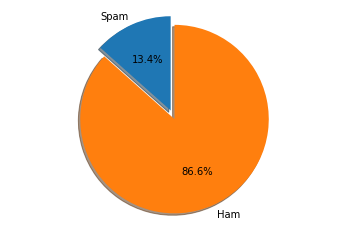

In [4]:
labels = 'Spam', 'Ham'
sizes = [percentage_of_spam, 1 - percentage_of_spam]
explode = (0.1, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

- czy wszystkie wiadomości są unikatowe? Jeżeli nie, jakie wiadomości najczęściej występują w każdej z klas? Czy jakaś wiadomość występuje w obu klasach?

In [5]:
def repeated(list1, list2):
    for i in range(len(list1)):
        for j in range(len(list2)):
            if list1[i] is list2[j]:
                return True
    return False

Nie wszystkie wiadomosci sa unikatowe
Najczesciej wystepujacy tekst w spamie to:
['Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!']
 natomiast w hamie to:
["Sorry, I'll call later"]
Brak wiadomosci powtorzonych


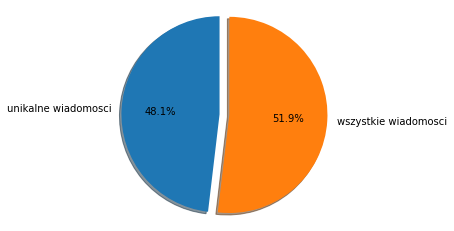

In [6]:
spam_texts = data['text'][data['label'] == 0]
ham_texts = data['text'][data['label'] == 1]
unique_lenght_in_text = len(set(data['text']))
length_in_text = len(data['text'])

if unique_lenght_in_text is length_in_text:
    print(f"Wszystkie wiadomosci sa unikatowe.")
else:
    print(f"Nie wszystkie wiadomosci sa unikatowe")
    most_frequent_spam_text = spam_texts.mode().to_numpy()
    most_frequent_ham_text = ham_texts.mode().to_numpy()
    print(f"Najczesciej wystepujacy tekst w spamie to:\n{most_frequent_spam_text}\n natomiast w hamie to:\n{most_frequent_ham_text}")

is_repeated = repeated(spam_texts, ham_texts)
print("Sa wiadomosci powtorzone") if is_repeated else print("Brak wiadomosci powtorzonych")

fig1, ax1 = plt.subplots()
ax1.pie([unique_lenght_in_text, length_in_text], explode=[0.1, 0], labels=["unikalne wiadomosci", "wszystkie wiadomosci"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

- jakiej długości są wiadomości?

In [ ]:
data['text_length'] = data['text'].apply(len)
print(f"Najdluzsza wartosc wynosi {max(data['text_length'])}, najmniejsza wynosi {min(data['text_length'])}")
fig = plt.figure()
ax = plt.axes()
plt.hist(data['text_length'], 50, facecolor='blue', alpha=0.5)
plt.xlabel('Długosc wypowiedzi')
plt.ylabel('Ilosc wystapien')
plt.show()

Najwięcej wiadomości jest krótkich, do około 20 znaków w wypowiedzi.

Text(0.5, 1.0, 'HAM')

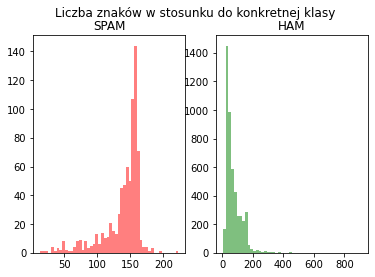

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Liczba znaków w stosunku do konkretnej klasy')
_ = ax1.hist(spam_texts.apply(len), 50, facecolor='red', alpha=0.5)
_ = ax2.hist(ham_texts.apply(len), 50, facecolor='green', alpha=0.5)
ax1.set_title('SPAM')
ax2.set_title('HAM')

Z histogramu wynika, że długości wiadomości typu Spam są statystycznie czesciej dluzsze niz wiadomości typu Ham.

 - jakie słowa najczęściej (top 16) występują w wiadomościach? Czy są różnice pomiędzy klasami?

In [10]:
def get_list_of_word_from_string(message):
    return re.sub("[^\w]", " ",  message.lower()).split()

In [11]:
get_element = lambda x, lista: [element[x] for element in lista]

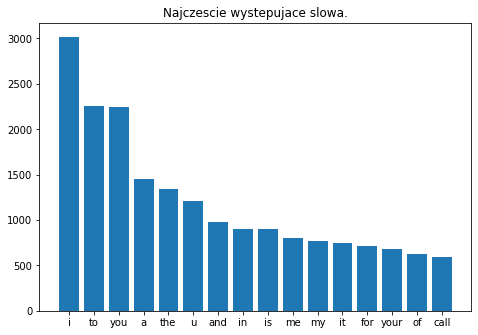

In [12]:
data['list_of_words'] = data['text'].apply(get_list_of_word_from_string)
top16 = Counter([x for sublist in data['list_of_words'] for x in sublist]).most_common(16)
top16_spam = Counter([x for sublist in data['list_of_words'][data['label']==0] for x in sublist]).most_common(16)
top16_ham = Counter([x for sublist in data['list_of_words'][data['label']==0] for x in sublist]).most_common(16)

top16_texts = get_element(0, top16)
top16_number = get_element(1, top16)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title('Najczescie wystepujace slowa.')
ax.bar(top16_texts,top16_number)
plt.show()

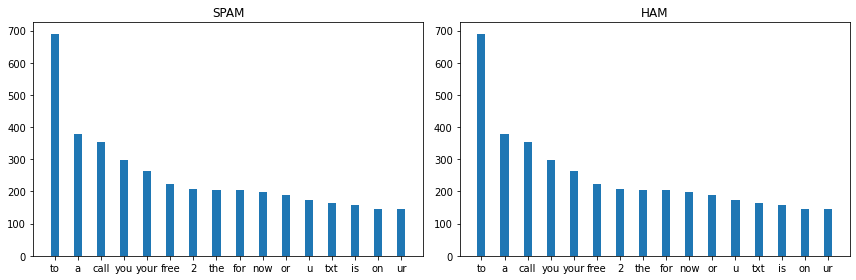

In [13]:
top16_texts_spam = get_element(0, top16_spam)
top16_number_spam = get_element(1, top16_spam)
top16_texts_ham = get_element(0, top16_ham)
top16_number_ham = get_element(1, top16_ham)
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
rects1 = ax1.bar(top16_texts_spam, top16_number_spam, width, label='SPAM')
rects2 = ax2.bar(top16_texts_ham, top16_number_ham, width, label='HAM')
ax1.set_title('SPAM')
ax2.set_title('HAM')
fig.tight_layout()
plt.show()


Najpopularniejsze (top16) wyrazy w obu zbiorach są takie same i w takiej samej liczebnosci.

- wyeliminuj znaki interpunkcyjne z wiadomości
- zamień wielkie litery na małe
- podziel wiadomości na tokeny (słowa)

zostało to zrobione wczesniej

- przekonwertuj tokeny na lemma (nltk.stem.wordnet.WordNetLemmatizer)

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/albert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
lemmatizer = WordNetLemmatizer()

lemmiatize_messages = lambda lista: [lemmatizer.lemmatize(element) for element in lista]

data['lemmiatize_messages'] = data['list_of_words'].apply(lemmiatize_messages)


 - dla losowych 8 wiadomości z każdej klasy porównaj wynik lemmizacji z wynikiem działania oryginalnego algorytmu Portera (nltk.stem.porter.PorterStemmer)

In [33]:
stemmer = PorterStemmer()
stemmize_messages = lambda lista : [stemmer.stem(element) for element in lista]
data['stemmize_messages'] = data['list_of_words'].apply(stemmize_messages)
samples = data.sample(n=8)
print(f"Lemmitize")
print([sample for sample in samples['lemmiatize_messages']])
print(f"Stemmize")
print([sample for sample in samples['stemmize_messages']])

Lemmitize
[['sense', 'foot', 'penis'], ['reckon', 'need', 'town', 'eightish', 'walk', 'carpark'], ['beautiful', 'girl', 'ive', 'ever', 'seen', 'baby', 'come', 'c', 'common', 'room'], ['yo', 'trip', 'got', 'postponed', 'still', 'stocked'], ['giving', 'second', 'chance', 'rahul', 'dengra'], ['ü', 'send', 'content', 'page'], ['send', 'print', 'da'], ['fun', 'fact', 'although', 'would', 'think', 'armand', 'would', 'eventually', 'build', 'tolerance', 'shit', 'considering', 'much', 'smoke', 'get', 'fucked', 'like', 'hit']]
Stemmize
[['there', 'is', 'no', 'sens', 'in', 'my', 'foot', 'and', 'peni'], ['reckon', 'need', 'to', 'be', 'in', 'town', 'by', 'eightish', 'to', 'walk', 'from', 'carpark'], ['u', 'r', 'the', 'most', 'beauti', 'girl', 'ive', 'ever', 'seen', 'u', 'r', 'my', 'babi', 'come', 'and', 'c', 'me', 'in', 'the', 'common', 'room'], ['yo', 'my', 'trip', 'got', 'postpon', 'you', 'still', 'stock', 'up'], ['they', 'r', 'give', 'a', 'second', 'chanc', 'to', 'rahul', 'dengra'], ['ü', 'onli'

Zbiory różnią się poszczególnymi elementami, za pomocą działania algorytmu Portera większe końcówki wyrazów są ucinane, często gubiąc znaczenie wyrazu.

- przy użyciu nltk.corpus.stopwords usuń słowa o małym znaczeniu czy lista ta jest wystarczająca aby poradzić sobie ze slangiem SMSowym? Jeżeli nie, uzupełnij ją.

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/albert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
def remove_stopwords_and_slang(lista):
    all_stopwords = stopwords.words('english') + ['u', 'ur', 'ure', 'im', 'doin', '4', '2', 'r']
    return [word for word in lista if word not in all_stopwords]

In [19]:
data['lemmiatize_messages'] = data['lemmiatize_messages'].apply(remove_stopwords_and_slang)

czy zmieniły się listy najczęściej występujących słów (lemm)?

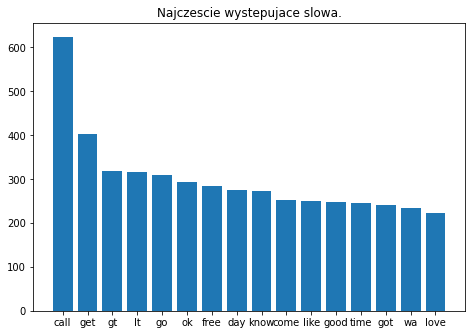

In [20]:
top16_changed = Counter([x for sublist in data['lemmiatize_messages'] for x in sublist]).most_common(16)
top16_spam_changed = Counter([x for sublist in data['lemmiatize_messages'][data['label']==0] for x in sublist]).most_common(16)
top16_spam_changed = Counter([x for sublist in data['lemmiatize_messages'][data['label']==0] for x in sublist]).most_common(16)

top16_changed_texts = get_element(0, top16_changed)
top16_changed_number = get_element(1, top16_changed)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title('Najczescie wystepujace slowa.')
ax.bar(top16_changed_texts, top16_changed_number)
plt.show()

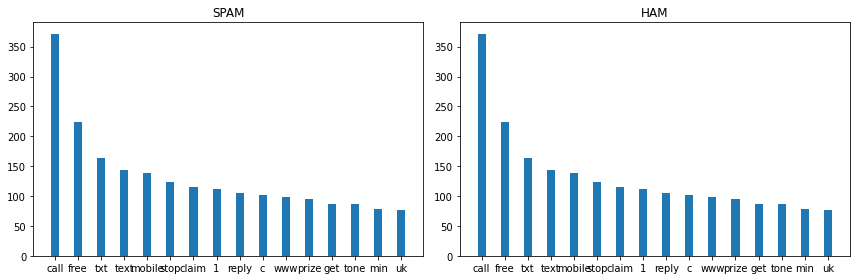

In [21]:
top16_changed_texts_spam = get_element(0, top16_spam_changed)
top16_changed_number_spam = get_element(1, top16_spam_changed)
top16_changed_texts_ham = get_element(0, top16_spam_changed)
top16_chnaged_number_ham = get_element(1, top16_spam_changed)
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
rects1 = ax1.bar(top16_changed_texts_spam, top16_changed_number_spam, width, label='SPAM')
rects2 = ax2.bar(top16_changed_texts_ham, top16_chnaged_number_ham, width, label='HAM')
ax1.set_title('SPAM')
ax2.set_title('HAM')
fig.tight_layout()
plt.show()


Lista zmieniła się, jest "odchudzona" o stopwordsow oraz slangu.

In [35]:
X = data['lemmiatize_messages']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
def dummy(doc):
    return doc

pipe = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
_ = pipe.fit(X_train, y_train)

In [38]:
y_prediction = pipe.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_prediction)
confusion_matrix

array([[ 161,   53],
       [   0, 1180]])

In [40]:
metrics.accuracy_score(y_test, y_prediction)

0.9619799139167863

W celu automatycznego usuwania spamu trzeba zminimalizować błąd, w którym wiadomości, które są spamem są traktowane jako wiadomosci ham.

Optymalizacja

In [41]:
def NWbias(alpha):
    global dummy 
    global X_train,y_train,y_test
    
    pipe = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)),
                     ('model', MultinomialNB(alpha=alpha))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    metrics.accuracy_score(y_test, y_pred)
    FP = cnf_matrix[0,1] 
    return FP

In [48]:
optimized = scipy.optimize.minimize_scalar(NWbias, method = "bounded", bounds = (0,20))

In [49]:
pipe = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)),   
             ('model', MultinomialNB(alpha=optimized['x']))])
pipe.fit(X_train, y_train)
y_predition = pipe.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_predition)
metrics.accuracy_score(y_test, y_predition)

0.9849354375896701

In [46]:
cnf_matrix

array([[ 202,   12],
       [   9, 1171]])

Wnioskując po macierzy bledow mozna zauwazyc, ze blad zostal zminimalizowany prawidlowo, otrzymujac jeszcze lepsza dokladnosc modelu.

Dummy Classifier

In [54]:
dummy_pipeline = Pipeline([('bow', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', DummyClassifier())])
_ = dummy_pipeline.fit(X_train, y_train)
y_predicted_dummy = dummy_pipeline.predict(X_test)
metrics.accuracy_score(y_test, y_predicted_dummy)

/home/albert/.local/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.7517934002869441

In [56]:
metrics.confusion_matrix(y_test, y_predicted_dummy)

array([[  21,  193],
       [ 153, 1027]])

Dummy Classfier poradził sobie znacznie gorzej z typowaniem czy dana wiadomość jest spamem czy nie, nie mógłby być uzyty do automatycznego usuwania spamu, ponieważ usunałby wiadomość relewantne. 

In [57]:
test = """Dear Sir:
I have been requested by the Nigerian National Petroleum Company to contact you for assistance in resolving a matter. The Nigerian National Petroleum Company has recently concluded a large number of contracts for oil exploration in the sub-Sahara region. The contracts have immediately produced moneys equaling US$40,000,000. The Nigerian National Petroleum Company is desirous of oil exploration in other parts of the world, however, because of certain regulations of the Nigerian Government, it is unable to move these funds to another region.
You assistance is requested as a non-Nigerian citizen to assist the Nigerian National Petroleum Company, and also the Central Bank of Nigeria, in moving these funds out of Nigeria. If the funds can be transferred to your name, in your United States account, then you can forward the funds as directed by the Nigerian National Petroleum Company. In exchange for your accommodating services, the Nigerian National Petroleum Company would agree to allow you to retain 10%, or US$4 million of this amount.
However, to be a legitimate transferee of these moneys according to Nigerian law, you must presently be a depositor of at least US$100,000 in a Nigerian bank which is regulated by the Central Bank of Nigeria.
If it will be possible for you to assist us, we would be most grateful. We suggest that you meet with us in person in Lagos, and that during your visit I introduce you to the representatives of the Nigerian National Petroleum Company, as well as with certain officials of the Central Bank of Nigeria.
Please call me at your earliest convenience at 18-467-4975. Time is of the essence in this matter; very quickly the Nigerian Government will realize that the Central Bank is maintaining this amount on deposit, and attempt to levy certain depository taxes on it.
Yours truly,
Prince Alyusi Islassis"""

In [62]:
list_of_text = get_list_of_word_from_string(test)
lemmiatized_text = lemmiatize_messages(list_of_text)
test = remove_stopwords_and_slang(lemmiatized_text)

In [63]:
y_pred = pipe.predict(test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Mail jest klasyfikowany w większości jako ham, czyli wiadomosc nie bedaca spamem, aczkolwiek z tresci merytorycznej maila mozna z latwoscia stwierdzic, ze ten mail jest spamem. Powodem blednej klasyfikacji moze byc fakt, ze w mailu jest uzyte bardzo duzo konstrukcji wyrazo-podobnych, ktore w modelu sa klasyfikowane jako wiadomosci typu ham.